# Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import data

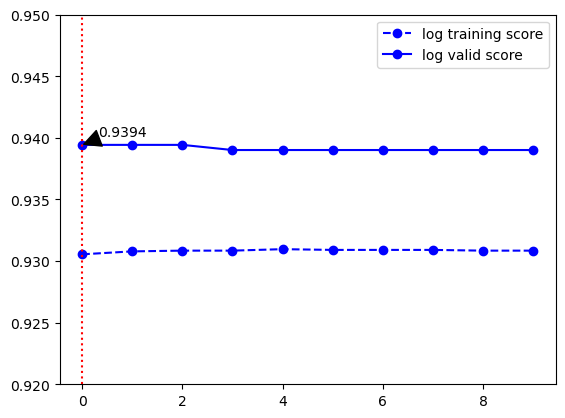

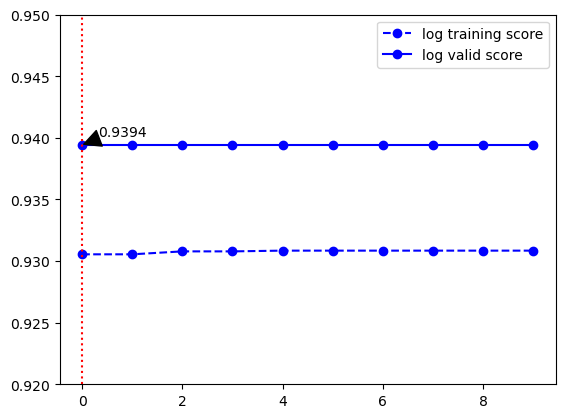

************************************************************
There are 6 set of X
X_train_selected_t1, X_train_selected_t2, X_valid_selected_t1,X_valid_selected_t2,X_test_selected_t1,X_test_selected_t2
------------------------------------------------------------
Normalized version
X_train_selected_t1_norm, X_train_selected_t2_norm, X_valid_selected_t1_norm,X_valid_selected_t2_norm,X_test_selected_t1_norm,X_test_selected_t2_norm
------------------------------------------------------------
There are 4 set of Y
y_train_t1, y_train_t2, y_valid_t1, y_valid_t2
when training, please use: 'y_train_t1_value,y_train_t2_value,y_valid_t1_value,y_valid_t2_value'
************************************************************


In [2]:
%run Data_preprocessing_realmean_final.ipynb

In [3]:

X_train_norm = X_train_selected_t1_norm
X_valid_norm = X_valid_selected_t1_norm
X_test_norm = X_test_selected_t1_norm

print(X_train_norm.shape)
print(X_valid_norm.shape)
print(X_test_norm.shape)


(16760, 52)
(2394, 52)
(4790, 52)


# Neural Network Using Sklearn build in function

In [4]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(hidden_layer_sizes=(100,), 
                   activation='relu',
                   solver='adam', 
                   alpha=0.0001, 
                   batch_size='auto', 
                   learning_rate='constant', 
                   learning_rate_init=0.01, 
                   power_t=0.5, 
                   max_iter=200, 
                   shuffle=True, 
                   random_state=None, 
                   tol=0.0001, 
                   verbose=False, 
                   warm_start=False, 
                   momentum=0.9, 
                   nesterovs_momentum=True, 
                   early_stopping=True, 
                   validation_fraction=0.1, 
                   beta_1=0.9, 
                   beta_2=0.999, 
                   epsilon=1e-08, 
                   n_iter_no_change=10, 
                   max_fun=15000)

clf.fit(X_train_norm, y_train_t2_value)

clf.score(X_valid_norm, y_valid_t2_value)

0.10778655117893088

In [5]:
y_pred = clf.predict(X_valid_norm)
rmse(y_pred, y_valid_t2_value)

NameError: name 'rmse' is not defined

# Evaluation Matrix

In [6]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Hyperparameter and setting tuning

## Layers

100%|███████████████████████████████████████| 100/100 [1:01:03<00:00, 36.64s/it]


[(1, 1), (1, 11), (1, 21), (1, 31), (1, 41), (1, 51), (1, 61), (1, 71), (1, 81), (1, 91), (11, 1), (11, 11), (11, 21), (11, 31), (11, 41), (11, 51), (11, 61), (11, 71), (11, 81), (11, 91), (21, 1), (21, 11), (21, 21), (21, 31), (21, 41), (21, 51), (21, 61), (21, 71), (21, 81), (21, 91), (31, 1), (31, 11), (31, 21), (31, 31), (31, 41), (31, 51), (31, 61), (31, 71), (31, 81), (31, 91), (41, 1), (41, 11), (41, 21), (41, 31), (41, 41), (41, 51), (41, 61), (41, 71), (41, 81), (41, 91), (51, 1), (51, 11), (51, 21), (51, 31), (51, 41), (51, 51), (51, 61), (51, 71), (51, 81), (51, 91), (61, 1), (61, 11), (61, 21), (61, 31), (61, 41), (61, 51), (61, 61), (61, 71), (61, 81), (61, 91), (71, 1), (71, 11), (71, 21), (71, 31), (71, 41), (71, 51), (71, 61), (71, 71), (71, 81), (71, 91), (81, 1), (81, 11), (81, 21), (81, 31), (81, 41), (81, 51), (81, 61), (81, 71), (81, 81), (81, 91), (91, 1), (91, 11), (91, 21), (91, 31), (91, 41), (91, 51), (91, 61), (91, 71), (91, 81), (91, 91)]


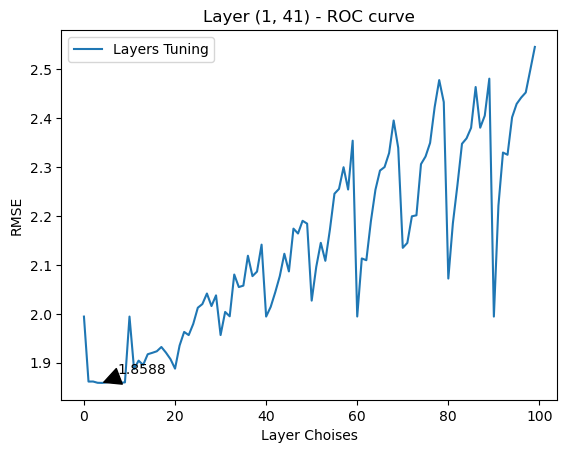

In [8]:
layer_list = []
rmse_lst=[]

for x in range (1,100,10):
    for y in range (1,100,10):
        layer_list.append((x,y))

for j in tqdm(range(len(layer_list))):
    i = layer_list[j]
    clf = MLPRegressor(solver="adam",
                        alpha=1e-5,
                        hidden_layer_sizes=i,
                        activation='relu',
                        random_state=1,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(layer_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(list(range(len(layer_list))), rmse_lst, label='Layers Tuning')
plt.xlabel('Layer Choises')
plt.ylabel('RMSE')
plt.title(f"Layer {layer_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

In [ ]:
best_layernumber = layer_list[index]
best_layernumber

## Solver

In [ ]:
solver_list = ["lbfgs","sgd","adam"]
rmse_lst=[]

for i in solver_list:
    clf = MLPRegressor(solver=i,
                        alpha=1e-5,
                        hidden_layer_sizes=best_layernumber,
                        random_state=1,
                        activation='relu',
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(solver_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(solver_list, rmse_lst, label='Solver Tuning')
plt.xlabel('Solver Choises')
plt.ylabel('RMSE')
plt.title(f"Solver {solver_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

In [ ]:
index = np.argmin(rmse_lst)
best_solver = solver_list[index]
best_solver

## Learning rate tuning

In [ ]:
lr_list = [1e-10,0.0001]+list(np.linspace(0.001,0.01,5))+list(np.linspace(0.01,0.1,5))+list(np.linspace(0.1,1,5))
rmse_lst=[]

for i in lr_list:
    clf = MLPRegressor(solver=best_solver,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate_init=i,
                        alpha=1e-5,
                        random_state=1,
                        activation='relu',
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(lr_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(lr_list, rmse_lst, label='Learning Rate Tuning')
plt.xlabel('Learning Rate Choises')
plt.ylabel('RMSE')
plt.title(f"Learning Rate {lr_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()
print(np.min(rmse_lst).round(4))

In [ ]:
index = np.argmin(rmse_lst)
best_lr_choice =  lr_list[index]
best_lr_choice

## Regularization strength tuning

In [ ]:
reg_list = list(np.linspace(1e-5,0.00005,20))
rmse_lst=[]

for i in reg_list:
    clf = MLPRegressor(solver=best_solver,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate_init=best_lr_choice,
                        alpha=i,
                        random_state=1,
                        activation='relu',
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(reg_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(list(range(len(reg_list))), rmse_lst, label='Regularization strength tuning')
plt.xlabel('Regularization strength Choices')
plt.ylabel('RMSE')
plt.title(f"Regularization strength tuning {reg_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

In [ ]:
index = np.argmin(rmse_lst)
best_reg_choice =  reg_list[index]
best_reg_choice

## Random State Tuning

In [ ]:
rs_list = list(range(1,3612,100))
rmse_lst=[]

for i in rs_list:
    clf = MLPRegressor(solver=best_solver,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate_init=best_lr_choice,
                        alpha=best_reg_choice,
                        random_state=i,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(rs_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(rs_list, rmse_lst, label=' Random State Tuning')
plt.xlabel(' Random State Choices')
plt.ylabel('RMSE')
plt.title(f" Random State Tuning {rs_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

In [ ]:
index = np.argmin(rmse_lst)
best_rs_choice =  rs_list[index]
best_rs_choice

## Activation function 

In [ ]:
activation_list = ['identity','logistic','tanh','relu']
rmse_lst=[]

for i in activation_list:
    clf = MLPRegressor(solver=best_solver,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate_init=best_lr_choice,
                        alpha=best_reg_choice,
                        random_state=best_rs_choice,
                        activation=i,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(activation_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(rs_list, rmse_lst, label=' Random State Tuning')
plt.xlabel(' Random State Choices')
plt.ylabel('RMSE')
plt.title(f" Random State Tuning {activation_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

# Test

In [ ]:
X = np.concatenate((X_train_norm,X_valid_norm),axis=0)
y = np.concatenate((y_train_t2_value,y_valid_t2_value),axis=0)

In [ ]:
# Final model
reg1 = MLPRegressor(hidden_layer_sizes=(20,1000), 
                   activation='logistic',
                   solver='adam', 
                   alpha=0.2,
                   learning_rate="adaptive", 
                   learning_rate_init=0.1, 
                   max_iter=300, 
                   shuffle=True, 
                   random_state=3612, 
                   warm_start=True, 
                   momentum=0.9, 
                   early_stopping=True, 
                   )

reg1.fit(X,y)
y_pred = reg1.predict(X_valid_norm)
rmse(y_pred, y_valid_t2_value)

In [ ]:
y_pred = reg1.predict(X_valid_norm)
rmse(y_pred, y_valid_t2_value)

In [ ]:
X_test_norm.describe()

In [ ]:

result = reg1.predict(X_test_norm)
res1 = pd.DataFrame(result.tolist(), columns=["Predicted"])
res1.index = X_test.index
res1.index.name = 'Id'
pd.DataFrame(res1).to_csv('out1.csv')
#print(torch.count_nonzero(torch.from_numpy(np.array(res1)).to(torch.float32)))
res1